# QR Factorisation

In this first part we will look at three different ways for computing the QR factorisation of a matrix. Remember that the goal is to start from a matrix $A$ and write it as the product of an orthogonal matrix $Q$ and an upper-triangular matrix $R$.

In [1]:
import numpy as np
import math
import numpy.linalg as npl
from numpy.linalg import norm

In [2]:
A = np.array([[1,2,3],[4,5,6],[7,8,0]])
n = 3

Numpy has a built-in function for doing this. Let's use it to check what the answer should be:

In [4]:
(Q,R) = npl.qr(A)
(Q,R)

(array([[-0.12309149,  0.90453403,  0.40824829],
        [-0.49236596,  0.30151134, -0.81649658],
        [-0.86164044, -0.30151134,  0.40824829]]),
 array([[-8.1240384 , -9.6011363 , -3.32347026],
        [ 0.        ,  0.90453403,  4.52267017],
        [ 0.        ,  0.        , -3.67423461]]))

## Gram-Schmidt orthogonalization

The first approach will be to transform the vectors in the columns of $A$ to a set of orthogonal vectores using the Gram-Schmidt approach. The basic idea of Gram-Schmidt is to build up an orthonormal set of vectors by projecting out non-orthogonal pieces. The following image illustrates this.

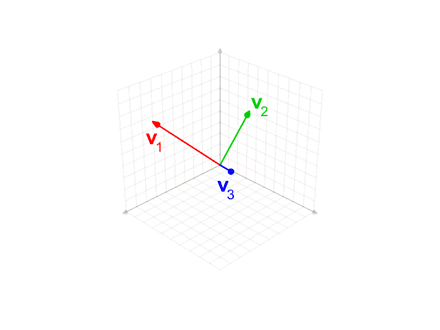

Let's now implement this with our test matrix $A$.

First, we construct three vectors $a_1$, $a_2$ and $a_3$ from the columns of $A$.

In [7]:
(a1, a2, a3) = np.transpose(A)

Now, our first orthonormal vector is just $a_1$ normalised to have length 1:

In [11]:
u1 = a1
e1 = u1 / norm(u1)

To construct our second orthonormal vector, let's start with $a_2$, project out the part along the $a_1$ direction and normalise the result:

In [13]:
u2 = a2 - (e1@a2)*e1
e2 = u2/norm(u2)

To construct our third orthonormal vector, let's project out the part along the previous two directions and normalise the result:

In [15]:
u3 = a3 - (e1@a3)*e1
u3 = u3 - (e2@a3)*e2
e3 = u3 / norm(u3)

Now we have our three orthogonal vectors, we can put them into the columns of Q

In [17]:
Q = np.transpose([e1, e2, e3])

To get $R$, we note that $A = Q R$ means that $Q^T A = Q^T Q R = R$ since $Q$ is an orthogonal matrix. Let's use this to compute $R$:

In [25]:
R = Q.T@A

In [27]:
Q

array([[ 0.12309149,  0.90453403, -0.40824829],
       [ 0.49236596,  0.30151134,  0.81649658],
       [ 0.86164044, -0.30151134, -0.40824829]])

In [29]:
R

array([[ 8.12403840e+00,  9.60113630e+00,  3.32347026e+00],
       [ 1.19904087e-14,  9.04534034e-01,  4.52267017e+00],
       [-1.46549439e-14, -1.86517468e-14,  3.67423461e+00]])

As expected, $R$ is (almost) an upper-triangular matrix. It is only __almost__ upper triangular because floating point arithmetic is not exact.

## Using Householder reflections

The Gram-Schmidt process can be a very effective way to orthogonalise a set of vectors, but it does run into problems with numerical stability. This can happen, for example, in the case where we are starting with vectors that are nearly linearly dependent. Then we would be subtracting two large vectors to produce one small one, and we know that this is a recipe for disaster with floating point arithmetic.

One way around this problem is to use a different approach to orthogonalization. A very popular method uses the idea of Householder reflections. These take a vector $x$ and reflect it about a plane defined by another vector $v$:
![Householder reflection](attachment:2b683c2c-0589-49a1-9696-f8fd12c8f7f0.png "Householder reflection")

This is clearly equivalent to multiplying $x$ by the __Householder reflection matrix__
$$ H = I - 2 \frac{v v^T}{||v||^2}$$
Note that $H$ is a *symmetric, orthogonal matrix*.

Now, if we choose $v$ appropriately then we can use it to zero out below the pivot in each column, thus producing $R$. In particular, if
$$v = a - ||a|| e_k$$ then $H a = |a| e_k$ so if $e_k$ is a unit vector in the $k$-th direction this does exactly what we want to the column $a$.

Let's now implement this in practice.
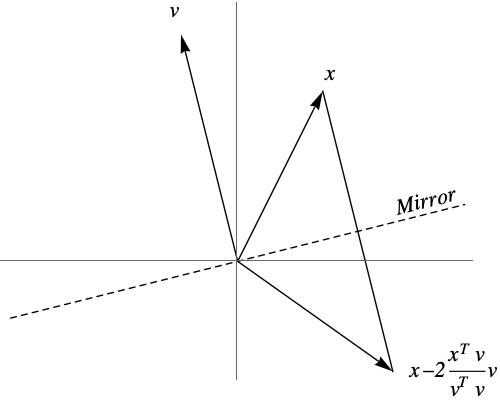

First, we work on the first column of $A$.

In [65]:
u1 = a1 - norm(a1)*np.array([1,0,0])
v1 = u1/norm(u1)
H1 = np.identity(3) - 2*np.outer(v1,v1)

In [69]:
A1 = H1@A
A1

array([[ 8.12403840e+00,  9.60113630e+00,  3.32347026e+00],
       [ 4.44089210e-16,  7.32119416e-01,  5.81837815e+00],
       [ 8.88178420e-16,  5.31208978e-01, -3.17838235e-01]])

and the second column

In [81]:
a2 = A1[1:,1]
u2 = a2 - (-np.sign(a2[0]))*norm(a2)*np.array([1,0])
print(u2)
v2 = u2/norm(u2)
print(v2)
H2 = np.identity(3)
H2[1:,1:] -= 2*np.outer(v2,v2)

[1.63665345 0.53120898]
[0.95115416 0.30871632]


In [83]:
A2 = H2@A1
print(A2)

[[ 8.12403840e+00  9.60113630e+00  3.32347026e+00]
 [-8.81044443e-16 -9.04534034e-01 -4.52267017e+00]
 [ 4.58079492e-16 -5.55111512e-17 -3.67423461e+00]]


and finally the third column

In [44]:
a3 = A2[2:,2]
u3 = a3 - (-np.sign(a3[0]))*norm(a3)*np.array([1])
v3 = u3/norm(u3)
H3 = np.identity(3)
H3[2:,2:] -= 2*np.outer(v3,v3)

In [85]:
A3 = H3@A2
A3

array([[ 8.12403840e+00,  9.60113630e+00,  3.32347026e+00],
       [-8.81044443e-16, -9.04534034e-01, -4.52267017e+00],
       [-4.58079492e-16,  5.55111512e-17,  3.67423461e+00]])

We now have transformed to exactly $R$.

In [49]:
R

array([[ 8.12403840e+00,  9.60113630e+00,  3.32347026e+00],
       [ 1.19904087e-14,  9.04534034e-01,  4.52267017e+00],
       [-1.46549439e-14, -1.86517468e-14,  3.67423461e+00]])

We can easily construct $Q$ from the Householder matrices:

In [87]:
Q_Householder = np.transpose(H3@H2@H1)

In [89]:
Q

array([[ 0.12309149,  0.90453403, -0.40824829],
       [ 0.49236596,  0.30151134,  0.81649658],
       [ 0.86164044, -0.30151134, -0.40824829]])

## Using Givens rotation matrices
QR decompositions can also be computed by exploiting **Givens rotation matrix**.
A Givens rotation is a rotation in the plane spanned by two coordinates axes. Given a pair of coordinates axes $(i,j)$ and an angle $\theta$, with $c=\cos(\theta)$ and $s=\sin(\theta)$, we define the Givens rotation matrix $G(i,j,\theta)$ as

![Givens rotation](GivensRotation.svg "Givens rotation")

The product $G(i,j,θ)x$ represents a counterclockwise rotation of the vector $x$ in the $(i, j)$ plane of $\theta$ radians.

Since $s^2 + c^2 = 1$, it is easy to check that $G$ is an *orthogonal matrix*.

By properly choosing $\theta$ one can use a Givens rotation matrix to rotate the vector $[0,\ldots,\underbrace{a}_i,\ldots,\underbrace{b}_j,\ldots,0]$
into the vector $[0,\ldots,\underbrace{r}_i,\ldots,\underbrace{0}_j,\ldots,0]$, where $r = \sqrt{a^2+b^2}$.
Hence, a sequence of Givens rotations can set to $0$ (one by one) the elements in the lower triangle of the matrix $A$.

**Note:** to build the Givens rotation matrix there's no need to compute the angle $\theta$. It is sufficient to observe that
$$\cos(\theta) = \frac{a}{r} \quad \text{ and } \quad \sin(\theta)=-\frac{b}{r}.$$

![Rotations](Rotations.png "Rotations")

Let's start by defining a function which, given $i$, $j$, $a$, and $b$ (and $n$) can return the Givens matrix needed to ``eliminate'' the $(j,i)$-th component of A. 

In [13]:
def Givens(i,j,a,b,n):
    """Compute matrix entries for Givens rotation."""
    r = math.hypot(a, b) #more stable than using sqrt(a**2 + b**2)
    c = a/r
    s = -b/r

    G = np.identity(n)
    G[i,i] = c
    G[j,j] = c
    G[j, i] = s
    G[i, j] = -s

    return G

In [ ]:
A

In [ ]:
G1 = Givens(0,2,A[0,0],A[2,0],3)

In [16]:
A1 = G1@A
A1

In [ ]:
G2 = Givens(0,1,A1[0,0],A1[1,0],3)

In [19]:
A2 = G2@A1
A2

In [ ]:
G3 = Givens(1,2,A2[1,1],A1[2,1],3)

In [22]:
A3 = G3@A2
A3

Again, we can easily construct $Q$ from the Givens matrices. Indeed,
$$ R = G_3 G_2 G_1 A \quad\Leftrightarrow A = G_1^T G_2^T G_3^T R $$

In [24]:
Q_Givens = G1.T@G2.T@G3.T

array([[ 0.12309149,  0.90453403, -0.40824829],
       [ 0.49236596,  0.30151134,  0.81649658],
       [ 0.86164044, -0.30151134, -0.40824829]])

In [ ]:
Q

In [ ]:
np.linalg.norm(A-G1.T@G2.T@G3.T@A3)

### Pros and cons
**Cons** Proceeding via Givens rotations requires a larger number of steps since it works element-wise.

**Pros** Setting an element $a_{ij}$ to zero affects only the elements indexed by $i$ and $j$. This makes Givens rotations more suitable for sparse matrices, where only few elements in the lower triangle are nonzero. Furthermore, the Givens QR decomposition is more bandwidth efficient and parallelizable than the Householder one.

# QR decomposition and eigenvalues
We have seen how we can decompose $A$ into the product of an orthogonal matrix $Q$ and an upper triangular matrix $R$.

It is easy to check that
$$ \prod_{i=1}^n \lambda_i(A) = \mathrm{det}(A) = \mathrm{det}(R) = \prod_{i=1}^n r_{ii} $$
This, however, gives no specific information on the eigenvalues $\lambda_i$, since $A$ and $R$ are not similar matrices. 

## The Schur decomposition of a square matrix
Let $A\in\mathbb{R}^{n\times n}$ then it is always possible to find an orthogonal matrix $Q$ and an (quasi-)upper triangular matrix $U$ (the decomposition is not unique) such that
$$ A=QUQ^T$$
$U$ is called the **Schur form** of $A$, and it is triangular if $A$ has real eigenvalues. Note that if $A$ is normal then its Schur form is diagonal and the Schur decomposition coincides with the orthogonal eigendecomposition and the SVD of $A$.

### The QR algorithm (a.k.a. the _Francis QR step_)
The QR decomposition of a matrix can be exploited to build its Schur decomposition as follows.

Set $A_0 = A$, we can decompose $A_0$ as $A_0=Q_0 R_0$, with $Q_0$ orthogonal and $R_0$ upper triangular.

We can set $A_1 = R_0 Q_0 (\neq A)$ and perform a second QR decomposition, i.e., $A_1 = Q_1 R_1$.

We can reiterate the process and write $R_1 Q_1 \equiv A_2 = Q_2 R_2$.

If we proceed, after $k$ steps we can write
$$A_{k+1} = R_kQ_k = Q_k^T Q_k R_k Q_k = Q_k^T A_k Q_k$$
which, going down to $A_0$ gives
$$A_{k+1} = Q_k^T A_k Q_k = Q_k^TQ_{k-1}^T\cdots Q_0^T A Q_0\cdots Q_{k-1}Q_k$$
i.e., the matrices $\{A_s\}$ are all orthogonally similar to $A$.
Under certain conditions it can be shown that the sequence $\{A_s\}_{s=1,\ldots}$ converge to an upper triangular matrix, which is the Schur form of $A$

In [26]:
import matplotlib.pyplot as plt
A = np.random.rand(10,10)
A = A.T@A
A0 = A.copy()

We check if $A$ is normal. If so, we expect the Schur form to be diagonal.

In [ ]:
npl.norm(A@A.T-A.T@A)

In [ ]:
Q0,R0 = npl.qr(A0)
A1 = R0@Q0
plt.spy(abs(A1)>1e-10)

In [ ]:
Q1,R1 = npl.qr(A1)
A2 = R1@Q1
plt.spy(abs(A2)>1e-10)

In [ ]:
Q2,R2 = npl.qr(A2)
A3 = R2@Q2
plt.spy(abs(A3)>1e-10)

In [31]:
Ak = A
for i in range(50):
    Q,R = npl.qr(Ak)
    Ak = R@Q

In [ ]:
plt.spy(abs(Ak)>1e-10)

In [ ]:
Ak.diagonal()

In [ ]:
npl.eigvals(A)

**Observation:** The convergence of the $(j,i)$-th entry of $A_k$ to 0 is proportional to the ratio between $\lambda_j$ and $\lambda_i$

**Note:** Computing a QR decomposition at each step makes the algorithm quite expensive in its current form. Modern **practical variants** of the method perform an initial **orthogonal similarity transformation of $A$ into a matrix in _Hessemberg form_** (an almost upper triangular matrix with nonzero entries on the first subdiagonal). The QR decomposition of such a matrix only consists of bringing the subdiagonal to 0 (instead of the full lower triangle). Moreover, if $A$ is an Hessemberg matrix and $A=QR$, then also $RQ$ is Hessemberg. This **cuts the computational cost of the method by an order of magnitude!**